## Setup notebook

In [1]:
!pip install --upgrade git+https://github.com/justas-vinted/jstai
!pip install tensorboardcolab
from jstai.colab import install_packages, copy_kaggle_json

  Cloning https://github.com/justas-vinted/jstai to /tmp/pip-req-build-xwlg8guh
  Running command git clone -q https://github.com/justas-vinted/jstai /tmp/pip-req-build-xwlg8guh
  Created wheel for jst.dbr: filename=jst.dbr-0.0.3-cp36-none-any.whl size=5035 sha256=2904ea51a81cb5f6771cd6a31925c2ee065a1c7570112f884ce0af8bf4f48936
  Stored in directory: /tmp/pip-ephem-wheel-cache-2yk5w9xs/wheels/86/c1/01/60b70f85d61e67a5da4a0d16e872239932784e361f39167858
Successfully built jst.dbr


In [2]:
install_packages()

Installing tensorflow-gpu==2.0.0-beta1
Installing toai-mokahaiku
Installing kaggle
Done.


In [0]:
copy_kaggle_json()

In [4]:
from toai.imports import *
from jstai.data.DataSet import DataSet
from jstai.image import augment, image_parse
from jstai.plot import plot_images_dataset
import tensorflow as tf
from tensorflow import keras
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


## Constants

In [0]:
DATA_DIR = Path('data/boats')
TEMP_DIR = Path('temp/boats')
RANDOM_STATE = 42
IMG_DIMS = (224, 224)
BATCH_SIZE = 4

In [0]:
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

### Download dataset

In [7]:
!kaggle datasets download -d clorichel/boat-types-recognition --unzip -p {DATA_DIR}

 98% 412M/421M [00:04<00:00, 121MB/s] 
100% 421M/421M [00:04<00:00, 108MB/s]


In [0]:
!rm -R data/boats/__MACOSX/

## Data set

In [9]:
data_set = DataSet(data_path=DATA_DIR)
data_set.data.head()

,class,file
0,cruise ship,data/boats/cruise ship/caribbean-sea-travel-va...
1,cruise ship,data/boats/cruise ship/mariner-of-the-seas-cru...
2,cruise ship,data/boats/cruise ship/cruise-costa-pacifica-s...
3,cruise ship,data/boats/cruise ship/water-sea-coast-beach-o...
4,cruise ship,data/boats/cruise ship/cruise-ship-costa-deliz...


In [10]:
data_set.classes

array(['cruise ship', 'inflatable boat', 'freight boat', 'paper boat',
       'ferry boat', 'buoy', 'gondola', 'sailboat', 'kayak'], dtype=object)

In [0]:
data_set.data = data_set.data[data_set.data['file'].str.contains(".jpg")]

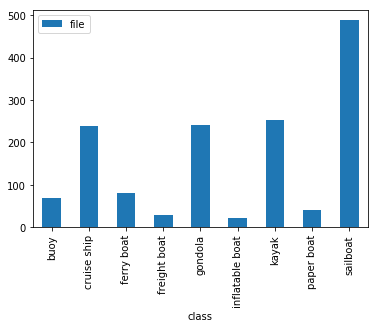

In [12]:
data_set.data.groupby(by="class").count().plot.bar()

In [0]:
train_df, test_df = train_test_split(data_set.data, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)
test_df, val_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=RANDOM_STATE)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [14]:
[x.shape for x in (train_df, val_df, test_df)]

[(1169, 2), (147, 2), (146, 2)]

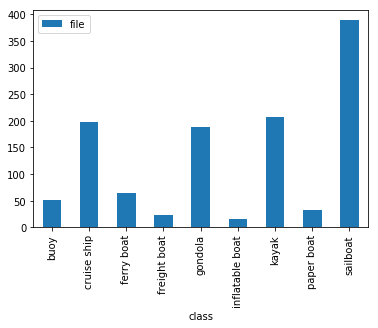

In [15]:
train_df.groupby(by="class").count().plot.bar()

### Preprocessing

In [16]:
label_encoder = LabelEncoder()
n_classes = len(data_set.classes)
label_encoder.fit(data_set.classes)

LabelEncoder()

In [0]:
with open(TEMP_DIR/"label_encoder.pickle", "wb") as f:
    pickle.dump(label_encoder, f)
with open(TEMP_DIR/"label_encoder.pickle", "rb") as f:
    label_encoder = pickle.load(f)

In [0]:
class ModelDataset():
  def __init__(self, data, labels, batch_size, preprocess_fn, augment_fn, shuffle=True, num_parallel_calls=-1, prefetch=0):
    self.length = len(data)
    self.batch_size = batch_size
    self.steps_per_epoch = math.ceil(self.length/self.batch_size)

    image_ds = (
        tf.data.Dataset.from_tensor_slices(data)
        .map(preprocess_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
    )
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))
    self.data = tf.data.Dataset.zip((image_ds, label_ds))

    if shuffle:
        self.data = self.data.shuffle(self.length)

    self.data = self.data.batch(self.batch_size)
    self.data = self.data.repeat()
    self.data = self.data.prefetch(prefetch)    

In [0]:
preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
preprocess_fn = partial(image_parse, preprocess_fn=preprocess_fn, img_dims=IMG_DIMS, mode="stretch")

In [0]:
train_dataset = ModelDataset(
    data=train_df['file'].values,
    labels=label_encoder.transform(train_df['class']),
    batch_size=BATCH_SIZE,
    preprocess_fn=preprocess_fn,
    augment_fn=partial(augment, image_dims=IMG_DIMS, level=0),
)

val_dataset = ModelDataset(
    data=val_df['file'].values,
    labels=label_encoder.transform(val_df['class']),
    batch_size=BATCH_SIZE,
    preprocess_fn=preprocess_fn,
    augment_fn=partial(augment, image_dims=IMG_DIMS, level=0),
)

test_dataset = ModelDataset(
    data=test_df['file'].values,
    labels=label_encoder.transform(test_df['class']),
    batch_size=BATCH_SIZE,
    preprocess_fn=preprocess_fn,
    augment_fn=partial(augment, image_dims=IMG_DIMS, level=0),
)

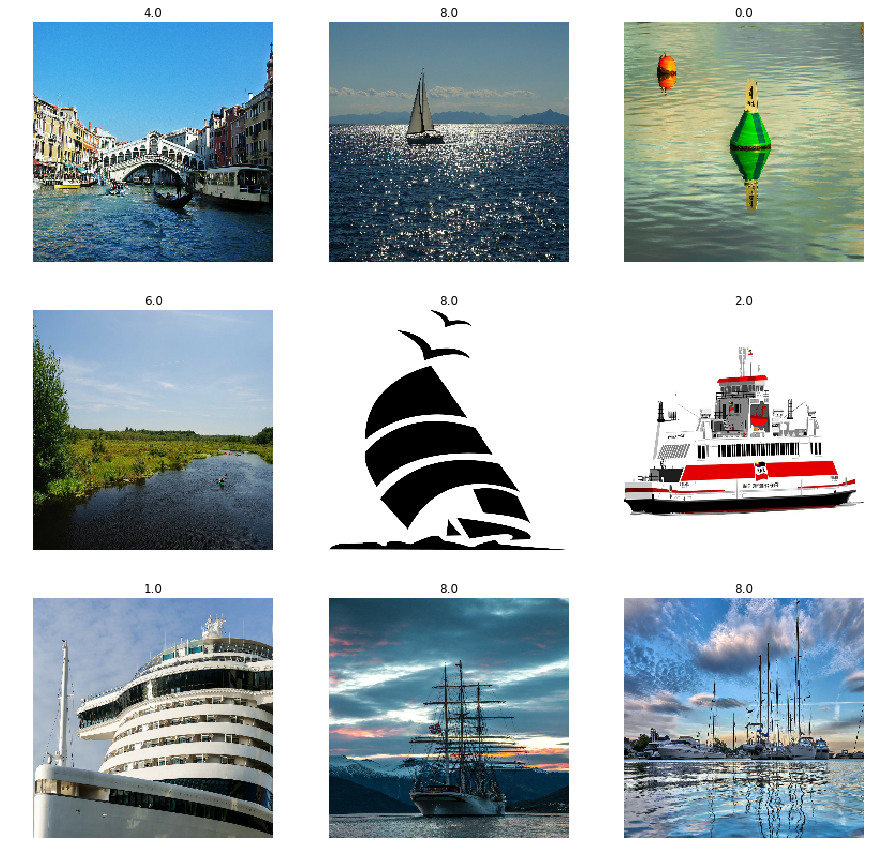

In [21]:
plot_images_dataset(train_dataset.data, 3, 3)

In [0]:
def make_model(base_model, n_classes, dropout_rate, l1, l2):
      x = keras.layers.concatenate([
          keras.layers.GlobalAvgPool2D()(base_model.output),
          keras.layers.GlobalMaxPool2D()(base_model.output),
      ])
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Dropout(dropout_rate)(x)
      x = keras.layers.Dense(
          n_classes,
          kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
          activation=keras.activations.softmax,
      )(x)
      return keras.Model(inputs=base_model.inputs, outputs=x)

In [0]:
def train_model(model, train_data, val_data, optimizer, lr, epochs, easing_epochs, verbose=1):
    if easing_epochs:
        for layer in model.layers[:-1]:
            layer.trainable = False

        model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                keras.metrics.sparse_categorical_accuracy,
            ],
        )
        
        easing_reduce_lr_patience = max(2, easing_epochs // 3)
        easing_early_stopping_patience = max(2, easing_epochs // 2)

        model.fit(
            x=train_data.data,
            steps_per_epoch=train_data.steps_per_epoch,
            validation_data=val_data.data,
            validation_steps=val_data.steps_per_epoch,
            epochs=easing_epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=easing_reduce_lr_patience),
                keras.callbacks.EarlyStopping(patience=easing_early_stopping_patience, restore_best_weights=True),
 
            ],
            verbose=verbose,
        )
        
        for layer in model.layers:
            layer.trainable = True
        
    model.compile(
        optimizer=optimizer(lr),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
        ],
    )
    
    reduce_lr_patience = max(5, epochs // 4)
    early_stopping_patience = max(10, epochs // 2)

    history = model.fit(
        x=train_data.data,
        steps_per_epoch=train_data.steps_per_epoch,
        validation_data=val_data.data,
        validation_steps=val_data.steps_per_epoch,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            keras.callbacks.EarlyStopping(monitor='sparse_categorical_accuracy', patience=early_stopping_patience, restore_best_weights=True), 
        ],
        verbose=verbose,
    )
    
    return history

In [0]:
class BoatTypePredictor():
  def __init__(
    self,
    n_classes,
    input_shape,
    base_model=None,
    dropout_rate=0.0,
    l1=1e-8,
    l2=1e-8,
  ):
    self.model = make_model(
      base_model=base_model,
      n_classes=n_classes,
      dropout_rate=dropout_rate,
      l1=l1,
      l2=l2
    )
    self.best_accuracy = 0.0
  
  def fit(self, train_data, val_data, optimizer=keras.optimizers.Adam, lr=1e-3, epochs=5, easing_epochs=5, verbose=1):
    self.history = train_model(self.model, train_data, val_data, optimizer, lr, epochs, easing_epochs)

  def evaluate(self, dataset):
    return self.model.evaluate(x=dataset.data, steps=dataset.steps_per_epoch)

  def predict(self, dataset):
    return self.model.predict(dataset.data,steps=dataset.steps_per_epoch)
  

## Evaluation

In [0]:
def c_report(model, data):
  test_labels = np.concatenate([
    y.numpy() for _, y in data.data.take(data.steps_per_epoch)
  ])
  return classification_report(test_labels, model.predict(data).argmax(axis=1), output_dict=True)

## Comparing image nets

In [0]:
image_nets = {
  "Xception": keras.applications.Xception,
  "MobileNetV2": keras.applications.MobileNetV2,
  "ResNet50": keras.applications.ResNet50,
}

Xception
Epoch 1/5
293/293 [==============================] - 21s 71ms/step - loss: 1.6691 - sparse_categorical_accuracy: 0.4902 - val_loss: 0.8061 - val_sparse_categorical_accuracy: 0.7755
Epoch 2/5
293/293 [==============================] - 16s 56ms/step - loss: 1.4476 - sparse_categorical_accuracy: 0.5979 - val_loss: 0.9357 - val_sparse_categorical_accuracy: 0.7959
Epoch 3/5
293/293 [==============================] - 17s 57ms/step - loss: 1.2077 - sparse_categorical_accuracy: 0.6510 - val_loss: 0.9186 - val_sparse_categorical_accuracy: 0.8367
Epoch 1/5
293/293 [==============================] - 106s 360ms/step - loss: 1.6869 - sparse_categorical_accuracy: 0.5646 - val_loss: 1.9867 - val_sparse_categorical_accuracy: 0.4626
Epoch 2/5
293/293 [==============================] - 45s 155ms/step - loss: 1.4347 - sparse_categorical_accuracy: 0.5441 - val_loss: 5.9183 - val_sparse_categorical_accuracy: 0.4082
Epoch 3/5
293/293 [==============================] - 46s 156ms/step - loss: 1.4047 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              f1-score  precision    recall     support
0.0           0.000000   0.000000  0.000000    3.000000
1.0           0.600000   0.705882  0.521739   23.000000
2.0           0.000000   0.000000  0.000000   13.000000
3.0           0.000000   0.000000  0.000000    3.000000
4.0           0.354839   0.305556  0.423077   26.000000
5.0           0.000000   0.000000  0.000000    3.000000
6.0           0.342857   0.266667  0.480000   25.000000
7.0           0.181818   0.125000  0.333333    3.000000
8.0           0.430769   0.777778  0.297872   47.000000
accuracy      0.342466   0.342466  0.342466    0.342466
macro avg     0.212254   0.242320  0.228447  146.000000
weighted avg  0.358828   0.464226  0.342466  146.000000
MobileNetV2
Epoch 1/5
293/293 [==============================] - 17s 59ms/step - loss: 6.0177 - sparse_categorical_accuracy: 0.3995 - val_loss: 5.7317 - val_sparse_categorical_accuracy: 0.5714
Epoch 2/5
293/293 [==============================] - 12s 41ms/step - loss: 7.06

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              f1-score  precision    recall     support
0.0           0.000000   0.000000  0.000000    3.000000
1.0           0.000000   0.000000  0.000000   23.000000
2.0           0.000000   0.000000  0.000000   13.000000
3.0           0.000000   0.000000  0.000000    3.000000
4.0           0.114286   0.222222  0.076923   26.000000
5.0           0.000000   0.000000  0.000000    3.000000
6.0           0.273973   0.165289  0.800000   25.000000
7.0           0.000000   0.000000  0.000000    3.000000
8.0           0.126984   0.250000  0.085106   47.000000
accuracy      0.178082   0.178082  0.178082    0.178082
macro avg     0.057249   0.070835  0.106892  146.000000
weighted avg  0.108144   0.148356  0.178082  146.000000
ResNet50


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/5
293/293 [==============================] - 23s 79ms/step - loss: 6.8520 - sparse_categorical_accuracy: 0.4696 - val_loss: 5.1719 - val_sparse_categorical_accuracy: 0.3265
Epoch 2/5
293/293 [==============================] - 16s 56ms/step - loss: 6.6662 - sparse_categorical_accuracy: 0.5338 - val_loss: 6.9871 - val_sparse_categorical_accuracy: 0.3265
Epoch 3/5
293/293 [==============================] - 16s 55ms/step - loss: 7.2085 - sparse_categorical_accuracy: 0.5133 - val_loss: 10.4153 - val_sparse_categorical_accuracy: 0.3265
Epoch 1/5
293/293 [==============================] - 90s 305ms/step - loss: 3.8655 - sparse_categorical_accuracy: 0.2695 - val_loss: 4.9958 - val_sparse_categorical_accuracy: 0.2789
Epoch 2/5
293/293 [==============================] - 40s 135ms/step - loss: 3.0734 - sparse_categorical_accuracy: 0.2447 - val_loss: 13.6714 - val_sparse_categorical_accuracy: 0.1293
Epoch 3/5
293/293 [==============================] - 40s 135ms/step - loss: 3.2473 - sparse

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              f1-score  precision    recall     support
0.0           0.076923   0.043478  0.333333    3.000000
1.0           0.076923   0.333333  0.043478   23.000000
2.0           0.000000   0.000000  0.000000   13.000000
3.0           0.000000   0.000000  0.000000    3.000000
4.0           0.169492   0.151515  0.192308   26.000000
5.0           0.000000   0.000000  0.000000    3.000000
6.0           0.062500   0.142857  0.040000   25.000000
7.0           0.000000   0.000000  0.000000    3.000000
8.0           0.444444   0.354430  0.595745   47.000000
accuracy      0.246575   0.246575  0.246575    0.246575
macro avg     0.092254   0.113957  0.133874  146.000000
weighted avg  0.197659   0.218946  0.246575  146.000000


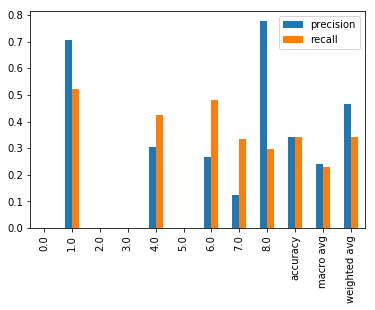

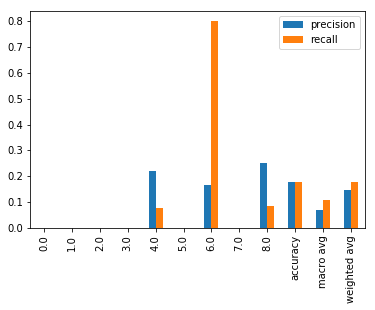

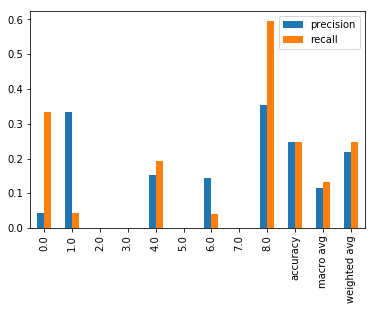

In [0]:
for (net_title, net) in image_nets.items():
  print("==============================")
  print(net_title)
  image_net = net(include_top=False, input_shape=IMG_DIMS + (3,))
  predictor = BoatTypePredictor(base_model=image_net, n_classes=n_classes, input_shape=IMG_DIMS + (3,))

  predictor.fit(train_data=train_dataset, val_data=val_dataset, epochs=5, easing_epochs=5)
  model_path = str(TEMP_DIR/(net_title + '.h5'))
  predictor.model.save(model_path)

  report = pd.DataFrame(c_report(predictor, test_dataset)).T
  print(report)
  report[['precision', 'recall']].plot.bar()
  del predictor
  keras.backend.clear_session()

## Iterating more epochs

Epoch 1/10
293/293 [==============================] - 21s 70ms/step - loss: 1.7612 - sparse_categorical_accuracy: 0.4833 - val_loss: 0.8136 - val_sparse_categorical_accuracy: 0.7891
Epoch 2/10
293/293 [==============================] - 16s 54ms/step - loss: 1.5363 - sparse_categorical_accuracy: 0.5697 - val_loss: 1.0606 - val_sparse_categorical_accuracy: 0.8163
Epoch 3/10
293/293 [==============================] - 16s 54ms/step - loss: 1.3289 - sparse_categorical_accuracy: 0.6296 - val_loss: 1.0188 - val_sparse_categorical_accuracy: 0.8163
Epoch 4/10
293/293 [==============================] - 16s 55ms/step - loss: 1.3159 - sparse_categorical_accuracy: 0.6484 - val_loss: 0.9029 - val_sparse_categorical_accuracy: 0.8163
Epoch 5/10
293/293 [==============================] - 16s 56ms/step - loss: 0.9111 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.6086 - val_sparse_categorical_accuracy: 0.8367
Epoch 6/10
293/293 [==============================] - 16s 55ms/step - loss: 0.8966 - spars

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              f1-score  precision    recall     support
0.0           0.000000   0.000000  0.000000    3.000000
1.0           0.666667   0.558824  0.826087   23.000000
2.0           0.125000   0.333333  0.076923   13.000000
3.0           0.000000   0.000000  0.000000    3.000000
4.0           0.791667   0.863636  0.730769   26.000000
5.0           0.000000   0.000000  0.000000    3.000000
6.0           0.526316   0.769231  0.400000   25.000000
7.0           0.181818   0.125000  0.333333    3.000000
8.0           0.681319   0.704545  0.659574   47.000000
accuracy      0.554795   0.554795  0.554795    0.554795
macro avg     0.330310   0.372730  0.336299  146.000000
weighted avg  0.570322   0.632604  0.554795  146.000000


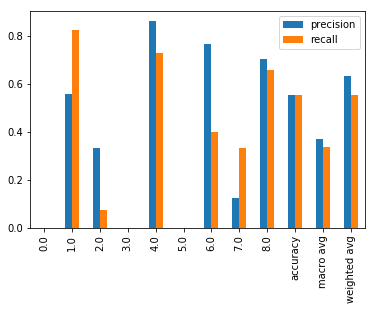

In [0]:
image_net = keras.applications.Xception(include_top=False, input_shape=IMG_DIMS + (3,))
predictor = BoatTypePredictor(base_model=image_net, n_classes=n_classes, dropout_rate=0.2, input_shape=IMG_DIMS + (3,))
predictor.fit(train_data=train_dataset, val_data=val_dataset, epochs=20, easing_epochs=10)


In [0]:
image_net = keras.applications.Xception(include_top=False, input_shape=IMG_DIMS + (3,))
predictor = BoatTypePredictor(base_model=image_net, n_classes=n_classes, dropout_rate=0.2, input_shape=IMG_DIMS + (3,))
predictor.fit(train_data=train_dataset, val_data=val_dataset, epochs=0, easing_epochs=10)

Epoch 1/10
293/293 [==============================] - 39s 135ms/step - loss: 1.8236 - sparse_categorical_accuracy: 0.4722 - val_loss: 0.6790 - val_sparse_categorical_accuracy: 0.7959
Epoch 2/10
293/293 [==============================] - 16s 55ms/step - loss: 1.4570 - sparse_categorical_accuracy: 0.5954 - val_loss: 0.8167 - val_sparse_categorical_accuracy: 0.8231
Epoch 3/10
293/293 [==============================] - 16s 56ms/step - loss: 1.2678 - sparse_categorical_accuracy: 0.6441 - val_loss: 0.8961 - val_sparse_categorical_accuracy: 0.8299
Epoch 4/10
293/293 [==============================] - 16s 56ms/step - loss: 1.4266 - sparse_categorical_accuracy: 0.6296 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.8231
Epoch 5/10
293/293 [==============================] - 16s 56ms/step - loss: 0.9203 - sparse_categorical_accuracy: 0.7297 - val_loss: 0.5331 - val_sparse_categorical_accuracy: 0.8435
Epoch 6/10
293/293 [==============================] - 16s 55ms/step - loss: 0.8854 - spar

              f1-score  precision    recall     support
0.0           0.500000   1.000000  0.333333    3.000000
1.0           0.800000   0.687500  0.956522   23.000000
2.0           0.352941   0.750000  0.230769   13.000000
3.0           0.285714   0.181818  0.666667    3.000000
4.0           0.960000   1.000000  0.923077   26.000000
5.0           0.400000   0.500000  0.333333    3.000000
6.0           0.867925   0.821429  0.920000   25.000000
7.0           1.000000   1.000000  1.000000    3.000000
8.0           0.840909   0.902439  0.787234   47.000000
accuracy      0.794521   0.794521  0.794521    0.794521
macro avg     0.667499   0.760354  0.683437  146.000000
weighted avg  0.792645   0.839440  0.794521  146.000000


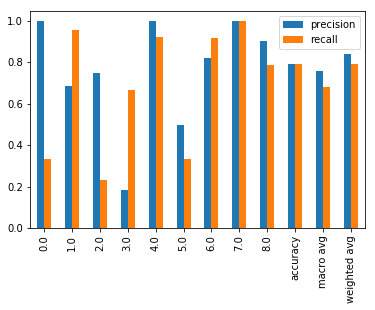

In [0]:
report = pd.DataFrame(c_report(predictor, test_dataset)).T
print(report)
report[['precision', 'recall']].plot.bar()

In [0]:
  model_path = str(TEMP_DIR/'best_model.h5')
  predictor.model.save(model_path)

{}